# X to Autosome Ratio

Here I perform a preliminary dosage compensation experiment in testis.

In [9]:
import os
import sys 
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.x_to_a import (CHROMS_CHR, MAJOR_ARMS_CHR, commonly_expressed, 
                                 idx_stats_by_cluster, multi_chrom_boxplot, x_autosome_boxplot)
from larval_gonad.plotting import make_figs
from larval_gonad.io import memory

# Setup notebook
nbconfig = Nb.setup_notebook('testis_pilot_scRNA_X_to_A', subproject_dir='../output/testis_pilot_scRNAseq_X_to_A',
                             seurat_dir='../output/testis_scRNAseq_pilot')

last updated: 2018-02-06 
Git hash: 09a7d0675ce316bb6e7637395f50ce2c18fdeb62


In [10]:
# Constants
BRIAN = ['dj', 'ocn', 'CG10920', 'boil', 'CG1314']  # CG12681 is not called boil
SHAR_PRIMARY = ['CG11635', 'CG18449', 'CG2127', 'CG3927']
SHAR_LATE = ['bb8', 'CG10252', 'djl', 'betaTub85D', 'fzo', 
             'Hsp60B', 'Hsp60C', 'Hsp60D', 'Cyt-c-d']
SHAR_POST = ['schuy', 'hale', 'sunz', 'sowi', 'boly', 't-cup', 'c-cup',
             'h-cup', 'm-cup', 'd-cup', 'wa-cup', 'f-cup', 'w-cup', 'orb', 'soti']

# Import data from testes
norm = nbconfig.seurat.get_normalized_read_counts()
clusters = nbconfig.seurat.get_clusters()

# Re-order columns
norm = norm[clusters.index].copy()
data = norm.T.join(clusters)

## Raw Read Counts By Cluster By Chromosome

First I plot the the raw read counts for each cluster by chromosome arm. Above the bars are the percent of reads going to that chromosome arm from cells in that cluster. We can see generally there are clusters with a larger number of reads {0, 1,3} and clusters with fewer reads {2, 4, 5, 6}. Cluster 4 has 13% of reads going to the X chromosome, cluster 3 has 16% of reads, and the remaining clusters havew around 19% of reads.

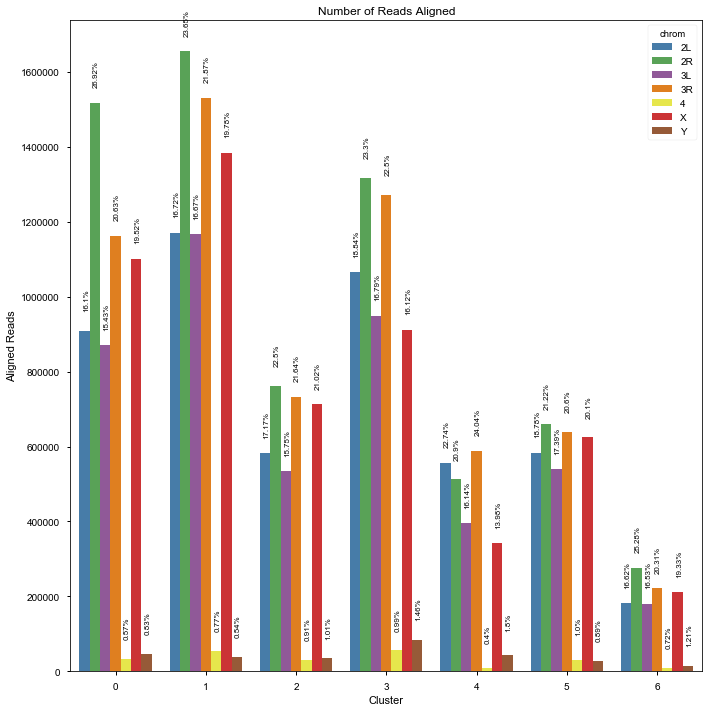

In [11]:
_results = idx_stats_by_cluster('../output/testis1/outs/possorted_genome_bam.bam', nbconfig.seurat.clusters)

@make_figs(nbconfig.fig_name('reads_per_chrom_per_cluster'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot_counts_by_cluster_by_chrom(dat):
    melted = dat.reset_index().melt(id_vars='chrom')
    melted.columns = ['chrom', 'cluster', 'value']
    
    prop = round(dat / dat.sum() * 100, 2).reset_index().melt(id_vars='chrom')
    prop = prop.sort_values(['chrom', 'variable']).set_index(['chrom', 'variable'])['value'].values

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.barplot(x='cluster', y='value', hue='chrom', data=melted, ax=ax, palette=nbconfig.color_chrom)
    ax.set_title('Number of Reads Aligned')
    ax.set_ylabel('Aligned Reads')
    ax.set_xlabel('Cluster');
    
    for i, j in zip(ax.patches, prop):
        ax.text(i.get_x() + .07, i.get_height() + 100000, f'{j}%', ha='center', rotation='vertical', fontsize=8)

plot_counts_by_cluster_by_chrom(_results)

## Expression Cutoff

We have seen in the literature that expression cutoffs have a large affect on dosage compensation measurements. This is especially true for scRNA-seq because data is sparse. Looking at these data thus far, we have seen interesting patterns showing evidence for Meiotic Sex Chromosome Silencing, but as I will show this is highly contingent on which gene expression cutoffs are used. I think if we understand the differences between the cutoffs we should be able to reconcile what they all show, and select the cutoff that shows this in the clearest light.

I present a series of box and whisker plots showing the distribution of normalized gene expression by major chromosome arm. Each panel represents cells that belong to a single cluster (0-6). I have also added additional metadata to the plot; the dashed line is the median expression for {2L, 2R, 3L, 3R} and represents median autosomal expression. "X Compensation" represents the amount X chromosome compensation compared to the autosomes `(median X / median autosome) * 2`. Here a value of 2 would indicate perfect compensation, a value of 1 would indicate no compensation, and a value of `nan` indicates not able to calculate because of zero division. Each panel also has the total number of cells present in the cluster `(n=## cells)` and the total number of expressed genes in the cluster `(g=## genes)`. The numbers above the whiskers are the number of genes expressed on the corresponding arm and the percent of genes from the arm.

### Expression Cutoff 1 (what I have been doing)

The first method is similar to what I have used before in large scale bulk RNA-seq expression datasets. We are typically only interested in genes that are well represented across most samples (cells). This method works well in controlled experiments that have roughly equal representation of sample classes, but I fear it adds artifacts given our dataset.

This method fist calculates an expression cutoff given some criteria (here: `# reads > 0`) for the entire datasets. It then considers a gene expressed if it is "on" in some fractions of samples (here: 1/3 of all cells). 

In [12]:
plt.rcParams['pdf.fonttype']

42

In [13]:
dat = data.groupby('cluster').median().T.loc[commonly_expressed(norm), :].reset_index()\
    .melt(id_vars='index')\
    .merge(nbconfig.fbgn2chrom, left_on='index', right_index=True)\
    .set_index('index')

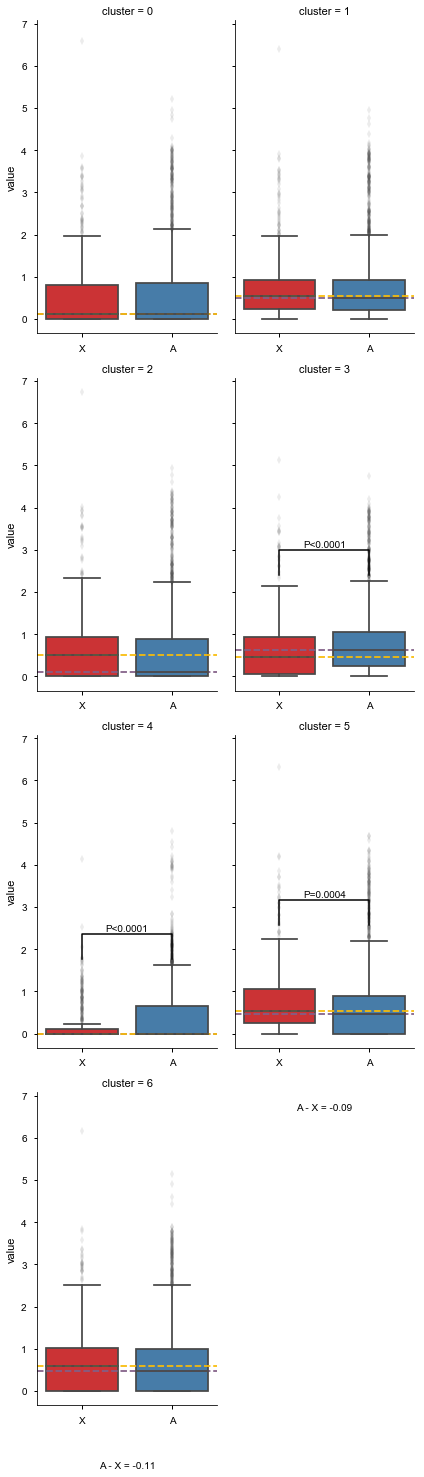

In [14]:
@make_figs(nbconfig.fig_name('boxplot_consistent_expressed_x_to_a'), styles=nbconfig.styles, formats=nbconfig.formats)
def _plot(data):
    g = sns.FacetGrid(data=dat, col='cluster', col_wrap=2, sharex=False, size=5, aspect=.6)
    g.map_dataframe(x_autosome_boxplot, 'chrom', 'value', flierprops=nbconfig.fliersprops, palette=nbconfig.color_xa)
    g.fig.subplots_adjust(hspace=.6)
    g.axes[-1].set_xlabel('')
    g.axes[-2].set_xlabel('');
    
_plot(dat)

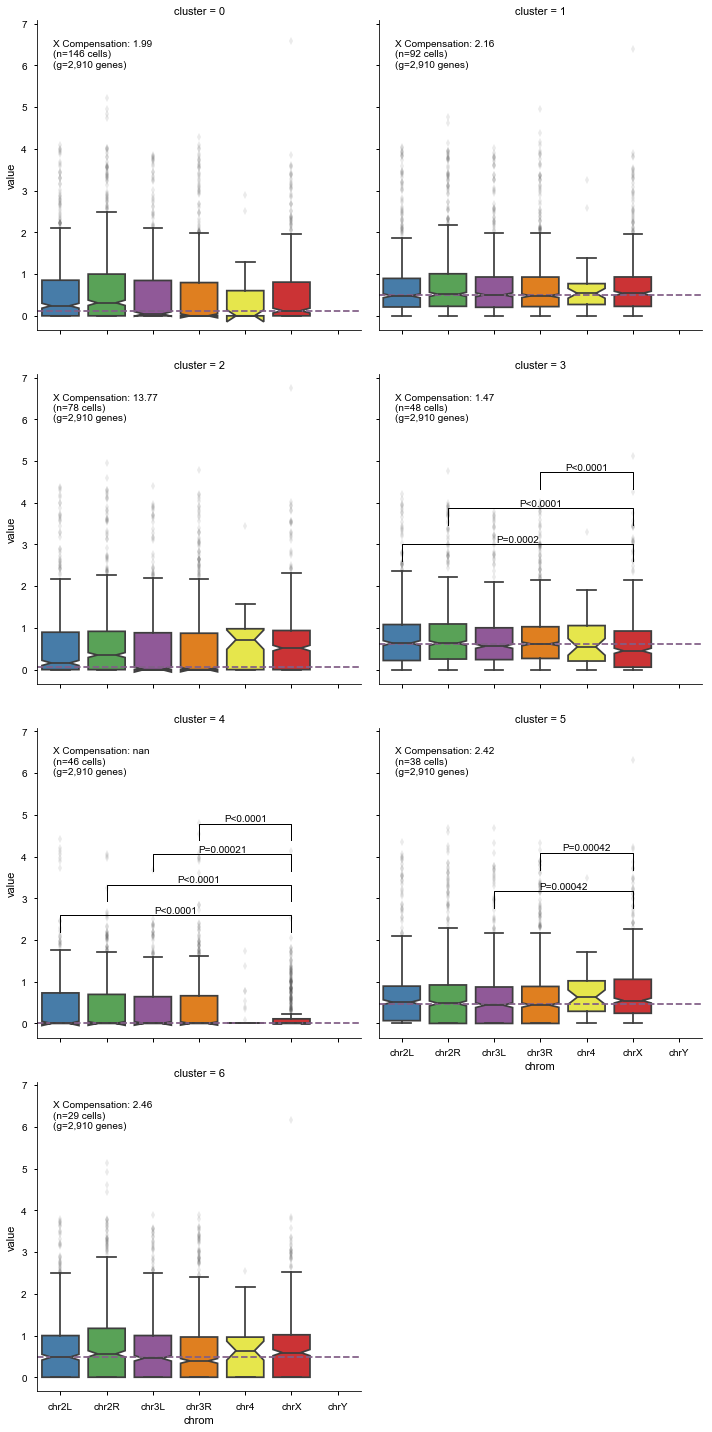

In [15]:
@make_figs(nbconfig.fig_name('boxplot_consistent_expressed_x_to_muller'), styles=nbconfig.styles, formats=nbconfig.formats)
def _plot():
    mpl.rcParams['pdf.fonttype'] = 42
    num_cells = data.groupby('cluster').count().iloc[:, 0].to_dict()
    g = sns.FacetGrid(dat, col='cluster', col_wrap=2, size=5)
    g.map_dataframe(multi_chrom_boxplot, 'chrom', 'value', num_cells=num_cells, palette=nbconfig.color_chrom, 
                    notch=True, flierprops=nbconfig.fliersprops)

_plot()

These plots show dosage compensation in somatic clusters {0, 1} and partial compensation in germ cell cluster {3} and MISC in late germ cell cluster {4}. Strangely there is over compensation in clusters {2, 5, 6}. 

Conceptually we consider a gene as expressed if it was "on" in ~160 cells. Because the cell numbers are so different among clusters, I think we are biasing for clusters that have more cells. Then clusters that have few cells will tend to have genes that have 0 expression still present because they were expressed in other clusters. I think this is what we are really seeing in cluster 4, which explains why expression for all chromosome arms is really low.

Interestingly, median genes expression of the X is similar among clusters {1, 2, 3, 5}, while cluster {0, 4} have a drop off to near 0. This could indicate that there are fundamentally different genes on the X being expressed in these clusters. We see a similar pattern with 3L and 3R in clusters {0, 2, 4} vs clusters {1, 3, 5, 6}.

### Expression Cutoff 2 (Cluster Cutoff)

The second method calculates the same expression cutoff given some criteria (here: # reads > 0) for the entire datasets. However, it then considers a gene expressed if it is "on" in some fractions of cells (here: 1/3 of cells) **within a cluster**. Conceptually it is similar as the first method, but handles the potential large differences in expression among cell types.

NameError: name 'fbgn2chrom' is not defined

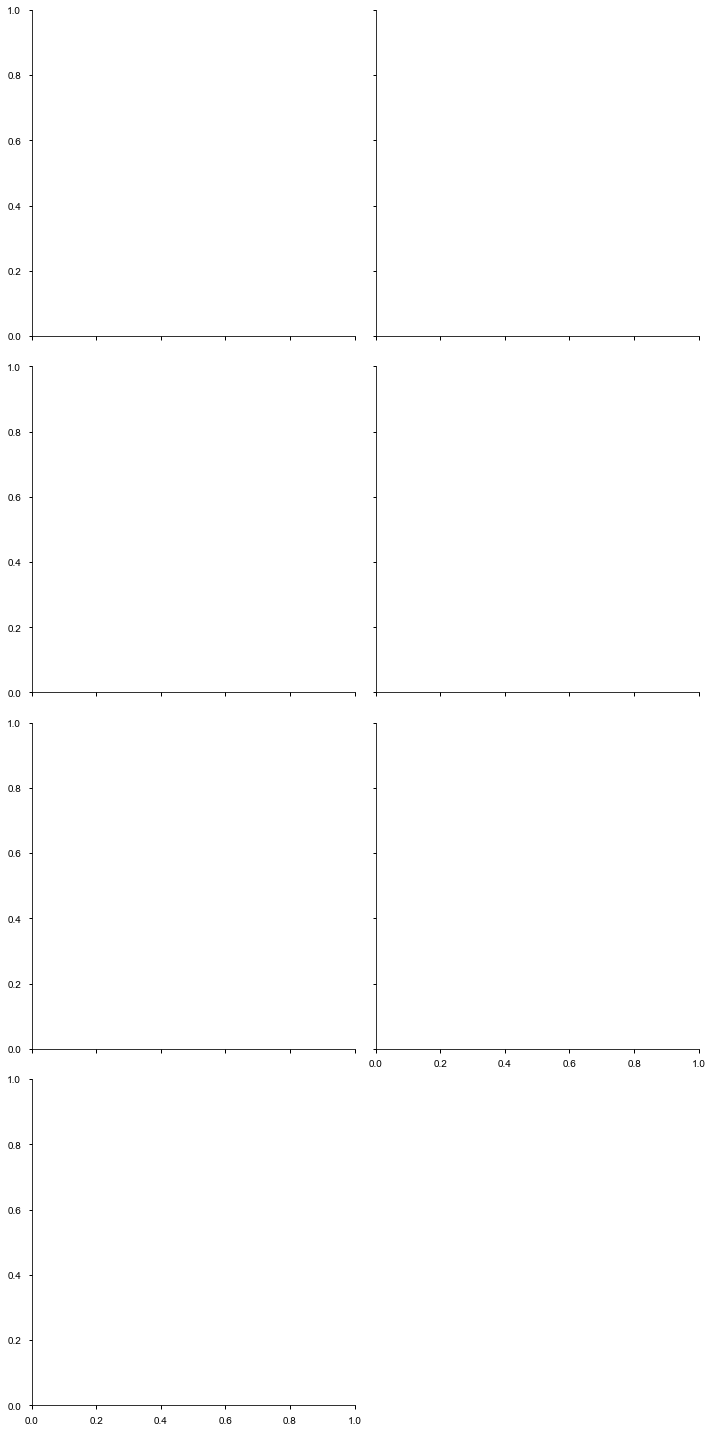

In [8]:
def expTwo(x, y, cutoff=0, **kwargs):
    # Determine which genes are expressed: # reads > 0 and on in 1/3 of cells within cluster
    dat = kwargs.pop('data').drop('cluster', axis=1)
    dat = dat.T
    num_cells = dat.shape[1]

    expressed = (dat > 0).sum(axis=1) > (num_cells / 3)

    # 2) calculate median
    dat = dat[dat.index.isin(expressed[expressed].index)].median(axis=1).to_frame()

    # clean up
    dat = dat.join(fbgn2chrom, how='left')
    dat.columns = [y, x]
    dat['log2'] = np.log2(np.exp(dat[y]))

    plot_boxplots(x, y, data=dat, num_cells=num_cells, **kwargs)

    
g = sns.FacetGrid(data, col='cluster', col_wrap=2, size=5)
g.map_dataframe(expTwo, 'Chromosome Arm', 'Normalized Expression', palette=nbconfig.colors, order=CHROMS_CHR, notch=True, fliersize=0, cutoff=1)
g.set(ylim=(None, 4.5));

Here all clusters except {3, 4} show full compensation. Clusters 3, 4 show partial compensation with around a 1.4 fold. Gene expression of the Y is only present in cluster 4. The number of expressed genes is highly variable ranging from 2,284 (cluster 0) to 4,992 (cluster 3). While the proportion of expressed X linked genes is stable ~16-17%, except for cluster 4 where there is a drop to 12% which has a corresponding up tick in 2L linked expression. While absolute numbers do not show evidence of MISC, if you look at these proportional differences, perhaps MISC is still a potential mechanism. 

### Expression cutoff 3

The third method calculates the same expression cutoff given some criteria (here: # reads > 0) for the entire datasets. However, it then considers a gene expressed if it is "on" in at least 3 cells **within a cluster**. This criteria is similar to what we are using for filtering genes during Seurat analysis.

In [ ]:
def expThree(x, y, cutoff=0, **kwargs):
    # Determine which genes are expressed: # reads > 0 and on in at least 3 cells within cluster
    dat = kwargs.pop('data').drop('cluster', axis=1)
    dat = dat.T
    num_cells = dat.shape[1]

    expressed = (dat > 0).sum(axis=1) >= 3

    # 2) calculate median
    dat = dat[dat.index.isin(expressed[expressed].index)].median(axis=1).to_frame()

    # clean up
    dat = dat.join(fbgn2chrom, how='left')
    dat.columns = [y, x]
    dat['log2'] = np.log2(np.exp(dat[y]))

    plot_boxplots(x, y, data=dat, num_cells=num_cells, **kwargs)

    
g = sns.FacetGrid(data, col='cluster', col_wrap=2, size=5)
g.map_dataframe(expThree, 'Chromosome Arm', 'Normalized Expression', palette=nbconfig.colors, order=CHROMS_CHR, notch=True, fliersize=0, cutoff=1)
g.set(ylim=(None, 4));

This method has a lot of cells with 0 counts, because of the high drop out rate in scRNA-seq, which drives all of the medians towards 0. This method looks to bias against clusters with a lot cells because this increases the likely hood of meeting this criteria. For example cluster 0 which has the most cells (n=146) has a median of 0 for all arms except for the 4th. This method shows some evidence of Y expression in clusters {0, 3, 4}. 

### Expression cutoff 4

The fourth method changes the expression cutoff to (here: # reads ≥ 3) for the entire datasets, and considers a gene expressed if it is "on" in at least 3 cells **within a cluster**. This method will shed some light on the typical magnitude of expression which we explored in the original preliminary analysis.

In [ ]:
def expFour(x, y, cutoff=0, **kwargs):
    # Determine which genes are expressed: # reads ≥ 3 and on in at least 3 cells within cluster
    dat = kwargs.pop('data').drop('cluster', axis=1)
    dat = dat.T
    num_cells = dat.shape[1]

    expressed = (dat >= 3).sum(axis=1) >= 3

    # 2) calculate median
    dat = dat[dat.index.isin(expressed[expressed].index)].median(axis=1).to_frame()

    # clean up
    dat = dat.join(fbgn2chrom, how='left')
    dat.columns = [y, x]
    dat['log2'] = np.log2(np.exp(dat[y]))

    plot_boxplots(x, y, data=dat, num_cells=num_cells, **kwargs)

    
g = sns.FacetGrid(data, col='cluster', col_wrap=2, size=5)
g.map_dataframe(expFour, 'Chromosome Arm', 'Normalized Expression', palette=nbconfig.colors, order=CHROMS_CHR, notch=True, fliersize=0, cutoff=1)
g.set(ylim=(None, 7.5));

Using this method, gene numbers are extremely low, and compensation is hard to interpret.

### Summary

To summarize, I think method 2 shows the most interpretable results. In general it looks as if all clusters except {3, 4} show full dosage compensation. Clusters {3, 4} show partial dosage compensation, with cluster 4 showing changes in the make up of the X linked genes used perhaps indicating MISC. The majority of Y linked expression is constrained to cluster 4. Of the genes considered expressed, expression is low typically less than 2 reads, which may cause problems trying to quantify dosage compensation.

## Explore Y Expression

The above plots show Y linked expression occurring primarily in cluster 4, with minor amounts of expression in cluster 0 and 3. Here I explore what genes are being expressed from the Y in these clusters plotted as a heatmap. Remember there are 113 genes on the Y, but I only have 21 genes in this dataset.

There are only a handful of cells in cluster 0 and cluster 3 that have expression of some Y linked genes. However, cluster 4 lights up with Y linked expression.

In [ ]:
# What genes are expressed on cluster 0?

_dat = data[data['cluster'] == 0].drop('cluster', axis=1).T.join(fbgn2chrom, how='left')
_dat = _dat[_dat.chrom == 'chrY'].drop('chrom', axis=1)

_dat.index = _dat.index.map(lambda x: fbgn2symbol[x])
_dat = _dat.loc[sorted(_dat.index, key=lambda x: x.lower())]

cg = sns.clustermap(_dat, row_cluster=False, xticklabels=False)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

col = cg.ax_row_dendrogram.get_position()
cg.cax.set_position([col.x0, col.y0, .05, col.height])
cg.cax.yaxis.set_ticks_position('left')
cg.cax.set_ylabel('Normalized Expression')
cg.cax.yaxis.set_label_position('left')
cg.ax_heatmap.set_title('Cluster 0: Y Linked Expression');
cg.ax_heatmap.set_xlabel('Cluster 0 Cells');
cg.ax_heatmap.set_ylabel('Y Linked Genes');

In [ ]:
# What genes are expressed on cluster 3?

_dat = data[data['cluster'] == 3].drop('cluster', axis=1).T.join(fbgn2chrom, how='left')
_dat = _dat[_dat.chrom == 'chrY'].drop('chrom', axis=1)

_dat.index = _dat.index.map(lambda x: fbgn2symbol[x])
_dat = _dat.loc[sorted(_dat.index, key=lambda x: x.lower())]

cg = sns.clustermap(_dat, row_cluster=False, xticklabels=False)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

col = cg.ax_row_dendrogram.get_position()
cg.cax.set_position([col.x0, col.y0, .05, col.height])
cg.cax.yaxis.set_ticks_position('left')
cg.cax.set_ylabel('Normalized Expression')
cg.cax.yaxis.set_label_position('left')
cg.ax_heatmap.set_title('Cluster 3: Y Linked Expression');
cg.ax_heatmap.set_xlabel('Cluster 3 Cells');
cg.ax_heatmap.set_ylabel('Y Linked Genes');

In [ ]:
# What genes are expressed on cluster 4?

_dat = data[data['cluster'] == 4].drop('cluster', axis=1).T.join(fbgn2chrom, how='left')
_dat = _dat[_dat.chrom == 'chrY'].drop('chrom', axis=1)

_dat.index = _dat.index.map(lambda x: fbgn2symbol[x])
_dat = _dat.loc[sorted(_dat.index, key=lambda x: x.lower())]

cg = sns.clustermap(_dat, row_cluster=False, xticklabels=False)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

col = cg.ax_row_dendrogram.get_position()
cg.cax.set_position([col.x0, col.y0, .05, col.height])
cg.cax.yaxis.set_ticks_position('left')
cg.cax.set_ylabel('Normalized Expression')
cg.cax.yaxis.set_label_position('left')
cg.ax_heatmap.set_title('Cluster 4: Y Linked Expression');
cg.ax_heatmap.set_xlabel('Cluster 4 Cells');
cg.ax_heatmap.set_ylabel('Y Linked Genes');

## Explore Male Sterile Genes

Next I generated a list of genes form FlyBase that have a male sterile phenotype. Like above I plot normalized expression for clusters {3, 4} as a heatmap.

In [ ]:
# get male sterile data
with open('../data/external/FlyBase_male_sterile.txt') as fh:
    male_sterile = []
    for row in fh:
        if row.startswith('#'):
            continue
        male_sterile.append(row.strip())

In [ ]:
# What genes are expressed on cluster 3?

_dat = data[data['cluster'] == 3].drop('cluster', axis=1).T.join(fbgn2chrom, how='left')
_dat = _dat[_dat.index.isin(male_sterile)].drop('chrom', axis=1)

_dat.index = _dat.index.map(lambda x: fbgn2symbol[x])
_dat = _dat.loc[sorted(_dat.index, key=lambda x: x.lower())]

cg = sns.clustermap(_dat, xticklabels=False, row_cluster=False, figsize=(10, 100))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

col = cg.ax_heatmap.get_position()
cg.cax.set_position([col.x0-.1, col.y1-.01, .05, .01])
cg.cax.yaxis.set_ticks_position('left')
cg.cax.set_ylabel('Normalized Expression')
cg.cax.yaxis.set_label_position('left')
cg.ax_heatmap.set_title('Cluster 3: Male Sterile Genes');
cg.ax_heatmap.set_xlabel('Cluster 3 Cells');
cg.ax_heatmap.set_ylabel('Male Sterile Genes');

In [ ]:
# What genes are expressed on cluster 4?

_dat = data[data['cluster'] == 4].drop('cluster', axis=1).T.join(fbgn2chrom, how='left')
_dat = _dat[_dat.index.isin(male_sterile)].drop('chrom', axis=1)

_dat.index = _dat.index.map(lambda x: fbgn2symbol[x])
_dat = _dat.loc[sorted(_dat.index, key=lambda x: x.lower())]

cg = sns.clustermap(_dat, xticklabels=False, row_cluster=False, figsize=(10, 100))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

col = cg.ax_heatmap.get_position()
cg.cax.set_position([col.x0-.1, col.y1-.01, .05, .01])
cg.cax.yaxis.set_ticks_position('left')
cg.cax.set_ylabel('Normalized Expression')
cg.cax.yaxis.set_label_position('left')
cg.ax_heatmap.set_title('Cluster 4: Male Sterile Genes');
cg.ax_heatmap.set_xlabel('Cluster 4 Cells');
cg.ax_heatmap.set_ylabel('Male Sterile Genes');

In [16]:
BRIAN_FBGN = [symbol2fbgn[x] for x in BRIAN]
SHAR_PRIMARY_FBGN = [symbol2fbgn[x] for x in SHAR_PRIMARY]
SHAR_LATE_FBGN = [symbol2fbgn[x] for x in SHAR_LATE]
SHAR_POST_FBGN = [symbol2fbgn[x] for x in SHAR_POST]

In [17]:
def plot_scatter(A, B, A_label=None, B_label=None, highlight=None, annotate=False, title=None):
    _A = A.median(axis=1)
    _B = B.median(axis=1)
    _fbgns = _A.index.intersection(_B.index).tolist()

    _chrx = fbgn2chrom.loc[_fbgns, 'chrom'] == 'chrX'
    _autosome = fbgn2chrom.loc[_fbgns, 'chrom'].isin(CHROMS_CHR) & (fbgn2chrom.loc[_fbgns, 'chrom'] != 'chrX')
    
    plt.scatter(_A.loc[_autosome], _B.loc[_autosome], s=3, c='k', label='Autosomes')
    plt.scatter(_A.loc[_chrx], _B.loc[_chrx], s=8, c='r', label='X')
    ax = plt.gca()
    plt.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], c='r', alpha=.4)

    ax.set_xlabel(f'Cluster {A_label}\nLn Normalized Expression')
    ax.set_ylabel(f'Cluster {B_label}\nLn Normalized Expression')
    
    if highlight is None:
        pass
    else:
        _hi = [x for x in highlight if x in _fbgns]
        plt.scatter(_A.loc[_hi], _B.loc[_hi], s=50, marker='^', c='b', label='Highlighted Genes')
    
        if annotate:
            for pt in zip(zip(_A.loc[_hi].values, _B.loc[_hi].values), _hi):
                plt.annotate(fbgn2symbol[pt[1]], pt[0], xytext=(10,0), textcoords='offset points', fontsize=18)

    plt.legend()
    
    if title is not None:
        ax.set_title(title)

In [18]:
#plot_scatter(cluster1, cluster2, 1, 2, BRIAN_FBGN, title='Brian')
#plot_scatter(cluster2, cluster5, 2, 5, BRIAN_FBGN, title='Brian')
#plot_scatter(cluster3, cluster2, 3, 2, BRIAN_FBGN, title='Brian')
#plot_scatter(cluster4, cluster2, 4, 2, BRIAN_FBGN, title='Brian')
#plot_scatter(cluster3, cluster4, 3, 4, BRIAN_FBGN, annotate=True, title='Brian')
#plot_scatter(cluster3, cluster4, 3, 4, SHAR_PRIMARY_FBGN, annotate=True, title='Primary')
#plot_scatter(cluster3, cluster4, 3, 4, SHAR_LATE_FBGN, annotate=True, title='Late')
#plot_scatter(cluster3, cluster4, 3, 4, SHAR_POST_FBGN, annotate=True, title='Post')